# Lab 4 - Linear models - modelling height of !Kung people

During the excercise, we will be covering design of model for heights of certain population of people.
Specific tasks are in the laboratory notebook, following there are specifications for the required models. 

<hr>


In [10]:
from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import scipy.stats as stats
import seaborn as sns

import matplotlib.pyplot as plt
import pandas as pd

### Ex. 1 Prepare the models:

```height_1_ppc.stan```


Generated quantities model, that would sample $\mu$ from normal prior distribution. It is supposed to represent our general knowledge about heights of people so assign reasonable mean height and standard deviation of those values. Our measurement error is unknown, but reasonably it would be on average 15 cm, propose a distribution and parameters for prior of standard deviation $\sigma$. Finally sample measurement of ```height``` from normal distribution with previously sampled $\mu$ and $\sigma$. Use this model to select parameters for priors to provide reasonable spreads of heights. 

<hr>

```height_1_fit.stan```

Create a model for fitting model without predictors. 
For this purpose:

- specify ```data``` block with ```N``` samples, and input real array of size ```N``` called ```heights```
- specify ```parameters``` block with $\mu$ and $\sigma$ (set up appropriate types and constraints)
- in ```model``` block specify priors with appropriately selected parameters and normal likelihood using those parameters.
- in ```generated quantites``` block sample a single height consistent with the model.

<hr>

```height_2a_ppc.stan```

Modify the previous prior predictive check model by:
- adding ```data``` block with ```N``` samples, and input real array of size ```N``` called ```weight```
- new variable $\alpha$ for intercept with same prior as $\mu$ in previous model
- add a standard normal prior for predictor coefficient $\beta$
- create a size ```N``` real array called ```height``` and with a ```for``` loop fill it with normal samples with standard deviation $\sigma$ and mean $\alpha+\beta\cdot\mathrm{weight}[i]$

<hr>

```height_2b_ppc.stan```

Modify the previous prior predictive check model to use lognormal distribution for $\beta$.  

<hr>

```height_2_fit.stan```

Modify previous model for fitting, by:
- adding to ```data``` block an input real array of size ```N``` called ```weight```
- adding to ```parameters``` a new one - $\beta$
- create a new block ```transformed parameters``` where with a ```for``` loop a new real array parameter of size [N] is created with $\mu=\alpha+\beta\cdot\mathrm{weight}[i]$
- in ```model``` add the prior for $\beta$ and evaluate likelihood in a loop over all values of $\mu$ array.
- in ```generated quantites``` block sample ```N``` dimensional array height over all values of $\mu$ array.
We focus on models in the form
    $$y \sim \mathrm{Normal}(\alpha+X\beta,\sigma)$$

We will try to fit $\mathrm{Normal}(\mu, \sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [2]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [3]:
d.describe()

,height,weight,age,male
count,352.000000,352.000000,352.000000,352.000000
mean,154.597093,44.990486,41.138494,0.468750
std,7.742332,6.456708,15.967855,0.499733
min,136.525000,31.071052,18.000000,0.000000
25%,148.590000,40.256290,28.000000,0.000000
50%,154.305000,44.792210,39.000000,0.000000
75%,160.655000,49.292693,51.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


#### Task 1. Prior predictive check

In [6]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
# changed it to write it in by hand
# data = {"mu":d.height.mean(), "sigma":d.height.std()}
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:compiling stan file /home/Lab4/height_1_ppc.stan to exe file /home/Lab4/height_1_ppc
INFO:cmdstanpy:compiled model executable: /home/Lab4/height_1_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [7]:
sim_df = sim.draws_pd()
sim_df

,lp__,accept_stat__,mu,sigma,height
0,0.0,0.0,174.853,17.3315,152.803
1,0.0,0.0,154.982,10.8317,157.649
2,0.0,0.0,163.230,21.7960,184.391
3,0.0,0.0,158.276,16.7968,157.906
4,0.0,0.0,164.103,13.9736,159.755
...,...,...,...,...,...
995,0.0,0.0,153.791,16.5634,166.787
996,0.0,0.0,150.873,11.4199,154.000
997,0.0,0.0,149.099,14.6963,150.145
998,0.0,0.0,154.071,15.7439,130.036


In [8]:
sim_df.describe()

,lp__,accept_stat__,mu,sigma,height
count,1000.0,1000.0,1000.000000,1000.000000,1000.000000
mean,0.0,0.0,154.295303,14.945527,155.377509
std,0.0,0.0,7.802581,3.019284,17.412460
min,0.0,0.0,131.821000,6.307570,95.601800
25%,0.0,0.0,149.042250,12.888850,143.972500
50%,0.0,0.0,154.171000,15.066300,155.222500
75%,0.0,0.0,159.683500,16.942100,165.386250
max,0.0,0.0,183.640000,25.082800,221.431000


<AxesSubplot:xlabel='height', ylabel='Density'>

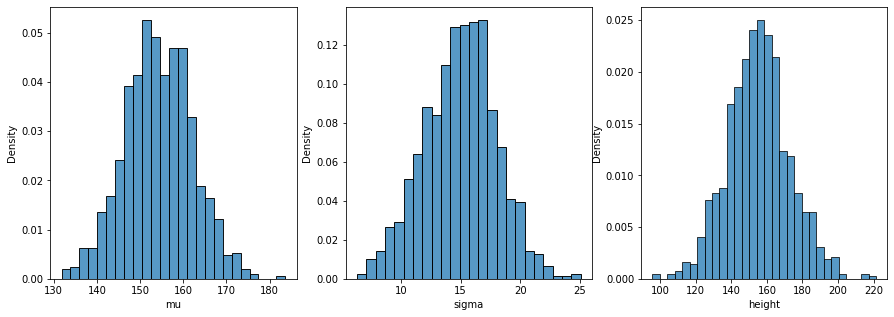

In [11]:
# plotting histograms of mu, sigma and simulated height

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(x="mu", data=sim_df, stat='density', ax=ax[0])
sns.histplot(x="sigma", data=sim_df, stat='density', ax=ax[1])
sns.histplot(x="height", data=sim_df, stat='density', ax=ax[2])

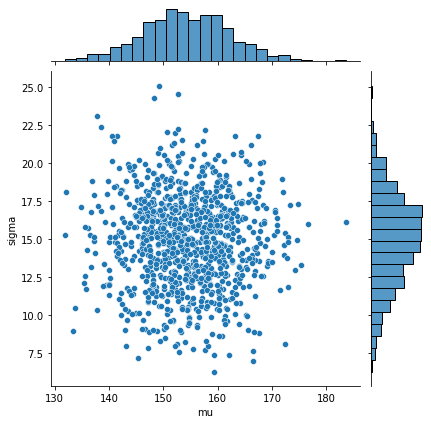

In [12]:
# plot a joint distribution of mu and sigma

sns.jointplot(data=sim_df, x="mu", y="sigma")

In [13]:
# they appear to be consistent with the prior to me - calculated 
# statistics such as mean and std are very close to the ones we go in the actual dataset, seems ok

### 2. Model fit and eval

In [14]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:compiling stan file /home/Lab4/height_1_fit.stan to exe file /home/Lab4/height_1_fit
INFO:cmdstanpy:compiled model executable: /home/Lab4/height_1_fit


In [15]:
fit=model_1_fit.sample(data=dict(N=len(d),heights=d.height.values),
                         seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status
chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)





chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [16]:
df = fit.draws_pd()
df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mean,sigma,h_hat
0,-894.124,0.737637,0.660898,2.0,7.0,0.0,895.270,153.811,7.53771,152.352
1,-891.850,1.000000,0.660898,2.0,3.0,0.0,893.888,154.773,7.84898,159.211
2,-893.687,0.925208,0.660898,3.0,7.0,0.0,893.945,154.464,8.42781,155.254
3,-894.386,0.954741,0.660898,3.0,7.0,0.0,894.874,155.034,8.47346,163.065
4,-894.013,1.000000,0.660898,1.0,1.0,0.0,894.455,154.967,8.43272,153.110


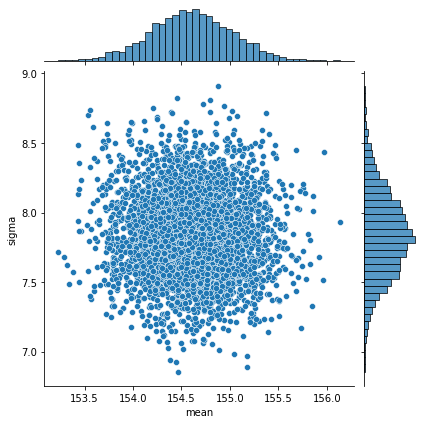

In [17]:
sns.jointplot(data=df, x='mean', y='sigma')

<AxesSubplot:xlabel='h_hat', ylabel='Density'>

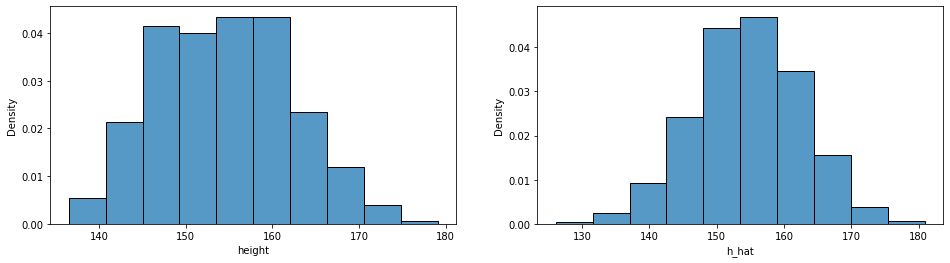

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
sns.histplot(x="height", data=d, stat='density', ax=ax[0], bins=10)
sns.histplot(x="h_hat", data=df, stat='density', ax=ax[1], bins=10)
# its not exactly perfect, model seems to have a bell shape, 
# while data seems to have a stronger tail towards bigger values only

### 3. Adding predictor to the model - weight

In [19]:
# Create column c_weight in the dataframe containing weights substrated by their mean.

d['c_weight'] = d['weight'] - d['weight'].mean()

In [20]:
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}

### 4. Prior predictive checks

In [22]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:compiling stan file /home/Lab4/height_2a_ppc.stan to exe file /home/Lab4/height_2a_ppc
INFO:cmdstanpy:compiled model executable: /home/Lab4/height_2a_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [23]:
ppc_df = sim.draws_pd()
ppc_df.head()

,lp__,accept_stat__,alpha,beta,sigma,height[1],height[2],height[3],height[4],height[5],...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,0.0,0.0,174.853,0.777181,11.1832,165.4620,149.003,167.800,178.960,191.394,...,197.290,205.850,202.516,188.713,170.851,180.796,184.281,196.372,191.528,196.042
1,0.0,0.0,144.768,-0.006780,14.9889,163.0720,156.243,155.941,162.508,163.030,...,184.752,144.316,131.185,142.322,130.389,152.391,129.053,143.160,164.202,143.509
2,0.0,0.0,150.712,-1.138640,11.3344,182.6160,163.686,163.261,171.195,168.059,...,156.712,121.125,152.559,138.475,156.119,133.294,143.718,136.787,130.504,132.634
3,0.0,0.0,146.438,-0.254452,13.4763,167.8900,140.922,146.712,136.634,146.343,...,150.876,145.270,148.297,162.189,136.760,136.061,154.384,135.735,147.490,137.054
4,0.0,0.0,146.351,1.671020,12.8918,89.4398,116.555,115.162,116.381,144.133,...,186.902,184.623,159.391,172.202,169.217,166.266,166.319,184.026,182.761,165.941


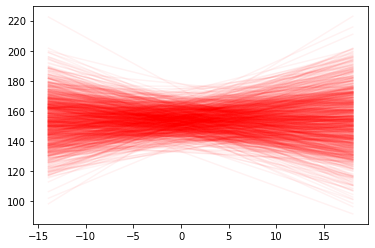

In [25]:
alpha = ppc_df['alpha'].values
beta = ppc_df['beta'].values
weight = np.linspace(d.c_weight.min(),d.c_weight.max(), R).reshape((R, 1))
h_hat = weight * beta + alpha
extended_domain = np.ones((1, R)) * weight
plt.plot(extended_domain, h_hat, 'r', alpha=0.05)
plt.show()

In [27]:
heights = ppc_df.drop(["lp__", "accept_stat__", "alpha", "beta", "sigma"], axis=1)

In [28]:
heights.mean().mean()
# mean makes sense, consistent with data

154.13669804199998

In [31]:
heights.values.std()
# also makes sens, close to our data's std, not identical tho

19.631914757250748

In [32]:
heights.min().min()

58.7084

In [33]:
heights.max().max()

246.371

In [34]:
# both max and min make sense, maximum height of a human was i think over 270cm

### 5. Modifying prior

In [35]:
# If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.

In [36]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:compiling stan file /home/Lab4/height_2b_ppc.stan to exe file /home/Lab4/height_2b_ppc
INFO:cmdstanpy:compiled model executable: /home/Lab4/height_2b_ppc


In [37]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [38]:
ppc_df = sim.draws_pd()
ppc_df.head()

,lp__,accept_stat__,alpha,beta,sigma,height[1],height[2],height[3],height[4],height[5],...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,0.0,0.0,174.853,2.175330,11.1832,146.0000,130.4530,150.1610,162.2310,175.576,...,214.263,223.733,221.309,208.417,191.467,202.322,206.719,219.720,215.787,221.211
1,0.0,0.0,144.768,0.993243,14.9889,149.1520,142.9750,143.3240,150.5430,151.716,...,196.891,157.106,144.627,156.416,145.134,167.787,145.101,159.859,181.553,161.511
2,0.0,0.0,150.712,0.320255,11.3344,162.3100,144.3300,144.8550,153.7390,151.554,...,174.421,139.785,172.170,159.036,177.630,155.755,167.130,161.150,155.817,158.897
3,0.0,0.0,146.438,0.775342,13.4763,153.5560,127.2590,133.7200,124.3120,134.692,...,163.377,158.442,162.140,176.703,151.944,151.916,170.910,152.932,165.357,155.593
4,0.0,0.0,146.351,5.317560,12.8918,38.6819,68.1728,69.1555,72.7499,102.878,...,231.168,231.264,208.407,223.594,222.984,222.409,224.838,244.921,246.031,231.587


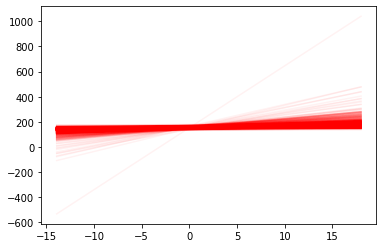

In [39]:
alpha = ppc_df['alpha'].values
beta = ppc_df['beta'].values
h_hat = weight * beta + alpha
plt.plot(extended_domain, h_hat, 'r', alpha=0.05)
plt.show()

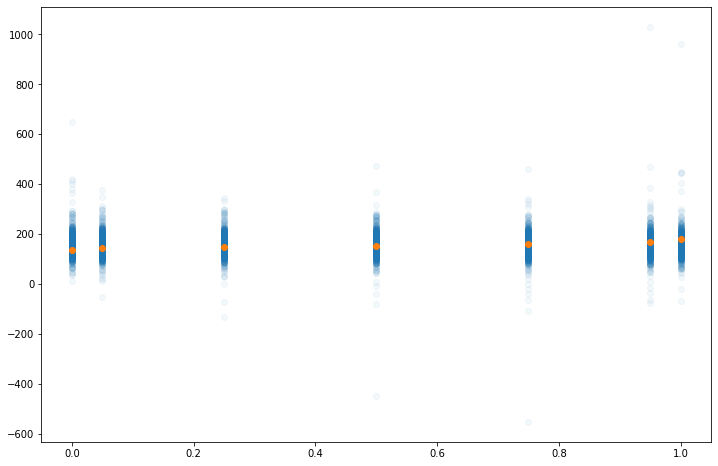

In [40]:
heights = ppc_df.loc[:, 'height[1]':'height[50]'].values
q = [0., 0.05, 0.25, 0.5, 0.75, 0.95, 1.]
quantiles = np.quantile(heights, q, axis=1)
data_quantiles = np.quantile(d.height, q)

plt.figure(figsize=(12, 8))
plt.scatter(q * np.ones((1000, 1)), quantiles, alpha=0.05, label='simulated')
plt.scatter(q, data_quantiles, label='data')

In [ ]:
# it looks like it makes sense - data (orange) can be achieved by the model (blue), definitely within its range
# however the model has a much broader range of values